# Hexbin Conversion
CFA commonly utilizes hexbins for aggregating spatial data. This user guide will demonstrate conversion between the unique hexbin IDs and each hexbin's associated latitude/longitude centroid. With centroids, you can calculate such metrics as distance from a point, the number of centroids located within a specific buffer area (i.e., number of hexbin centroids located within a 5 mile buffer around Chick-Fil-A), and aggregating the attribute data (i.e., find the total population of millenials within ten miles of a store location). 

We will demonstrate the process of converting the hexbins in the 'market optimization' dataset to latitude/longitude centroids, so that they can be queried as points (easier process to conduct within SQL). 

In [1]:
import h3
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt

### Libraries Used
This process primarily uses the `h3` library and `geopandas`. 

`h3` is an open-source library created by Uber Engineering to quickly and uniquely identify convert back and forth between hexbins and lat/longs at different resolutions - more information on the system they built can be found in this fascinating [document](https://eng.uber.com/h3/).   

`geopandas` is the most commonly used package for working with spatial data. It allows the user to quickly convert data into spatial dataframes and work with the attribute data the same as you would use dataframes in `pandas`. Additionally, it has functionality for importing and exporting a wide array of spatial data (shapefiles, geojson, geodatabase, kml). 
* Note: `geopandas` relies on an array of library dependencies that can be tricky to install. We recommend reading the installation and dependencies guide and a virtual environment. 

In [2]:
def visualize_hexagons(hexagons, color="red", folium_map=None):
    """
    hexagons is a list of hexcluster. Each hexcluster is a list of hexagons. 
    eg. [[hex1, hex2], [hex3, hex4]]
    """
    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        # flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    
    if folium_map is None:
        m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    else:
        m = folium_map
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
        m.add_child(my_PolyLine)
    return m

## Test Individual Points
We can go through and test individual lat/long pairs. You can right-click within Google Maps and copy the latitude and longitude on a point of interest to obtain a unique `hex_id`. The H3 package allows you to convert lat/long to unique hexbin identifiers and vice-versa. The `resolution` is needed to determine what size hexbin it falls into. For reference, a resolution of 1 equates to a hexagon of 4.2M km^2, while a resolution of 15 is equal to about 10 ft^2. We will use a resolution of 8, which equates to approximately 0.28 square miles. You need the resolution to convert lat/long to hexbins, but not vice-versa. 

In [3]:
# Latitude and Longitude from western Virginia
lat, lng = 36.803428, -81.200710
resolution = 8

In [4]:
# Determine unique identifer
h3_address = h3.geo_to_h3(lat, lng, resolution)
print(h3_address)

882a99b0b1fffff


### Visualization
This visualization shows how the structure of hexbins arrange from the queried hexbin. Hexbins have unique properties for analytics in that the centroid of all the neighboring hexagons are equidistant, unlike that of triangles or squares. The use case for this project came from Uber's difficulty in manually maintaining neighborhood and semantic boundaries in dense areas (such as NYC) and finding the right aggregation of data, especially with a global expansion push. 

The hexbin system balances accurate spatial location with semantic location. Within dense city cores they can modify the level of resolution to customize the granularity of the spatial data and still obtain valuable data. In addition, they could still link each hexagon to neighborhoods and popular areas within cities using spatial joins.  

The visualization below simply showcases how the hexagons align around a centralized hexbin. 

In [5]:
hex_center_coordinates = h3.h3_to_geo(h3_address) # array of [lat, lng]      
hex_boundary = h3.h3_to_geo_boundary(h3_address) # array of arrays of [lat, lng]                                                                                                                                                                                                                                                         
m = visualize_hexagons(list(h3.k_ring_distances(h3_address, 4)[3]), color="purple")
m = visualize_hexagons(list(h3.k_ring_distances(h3_address, 4)[2]), color="blue", folium_map=m)
m = visualize_hexagons(list(h3.k_ring_distances(h3_address, 4)[1]), color="green", folium_map=m)
m = visualize_hexagons(list(h3.k_ring_distances(h3_address, 4)[0]), color = "red", folium_map=m)
display(m)

### Market Optimization Dataset
We can read in the market optimization data, which contains the `hex_id` identifier. This is an extracted .csv from DBeaver, but you can also read in this data using AWS Wrangler, which will be covered in a later section. 

This specific dataset contains ~335k rows - we will convert `hex_id` to a seperate latitude and longitude value, which can then be converted to a spatial object that can be used for analysis. Additionally, we will retain all attribute data (i.e., population of millenials), which can be aggregated in analysis.  

In [6]:
# Read in our dataframe
# 335k Records in the dataframe
df = pd.read_csv('../../01_Data/01_Initial/market_optimization.csv')
df

,hex_id,store,status,hasdata,populationtotals_totpop_cy,food_x1130_x,generations_millenn_cy,populationtotals_dpopwrk_cy,electronicsinternet_mp19078a_b,tapestryhouseholdsnew_thhgrpl3,restaurants_mp29046a_b,groupquarters_gqcoll10,householdtotals_hhu18c10,filepath,insert_timestamp,load_date
0,8829a1d229fffff,4014,NaN,1.0,3347.0,2762044.0,1027.0,1032.0,210.0,0.0,309.0,0.0,502.0,s3://cfadatalakeprod-useast1-dl-common-0099-in...,2021-11-09 17:55:31.281,2021-11-09
1,88446b2addfffff,4725,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,s3://cfadatalakeprod-useast1-dl-common-0099-in...,2021-11-09 17:55:31.281,2021-11-09
2,8829a54957fffff,2682,NaN,1.0,1404.0,2991987.0,302.0,556.0,154.0,0.0,122.0,0.0,175.0,s3://cfadatalakeprod-useast1-dl-common-0099-in...,2021-11-09 17:55:31.281,2021-11-09
3,8844c175ebfffff,2077,NaN,1.0,0.0,0.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,s3://cfadatalakeprod-useast1-dl-common-0099-in...,2021-11-09 17:55:31.281,2021-11-09
4,8844dc202dfffff,2944,NaN,1.0,18.0,26059.0,4.0,2.0,0.0,0.0,0.0,0.0,3.0,s3://cfadatalakeprod-useast1-dl-common-0099-in...,2021-11-09 17:55:31.281,2021-11-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335136,8829b6ca59fffff,1967,NaN,1.0,0.0,0.0,0.0,509.0,0.0,0.0,0.0,0.0,0.0,s3://cfadatalakeprod-useast1-dl-common-0099-in...,2021-11-09 17:55:31.281,2021-11-09
335137,8848b38f4dfffff,3300,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,s3://cfadatalakeprod-useast1-dl-common-0099-in...,2021-11-09 17:55:31.281,2021-11-09
335138,882af635e5fffff,756,NaN,1.0,1158.0,1305669.0,301.0,855.0,35.0,0.0,90.0,0.0,145.0,s3://cfadatalakeprod-useast1-dl-common-0099-in...,2021-11-09 17:55:31.281,2021-11-09
335139,8826645717fffff,4220,NaN,1.0,0.0,0.0,0.0,59.0,0.0,0.0,0.0,0.0,0.0,s3://cfadatalakeprod-useast1-dl-common-0099-in...,2021-11-09 17:55:31.281,2021-11-09


### Data Reduction
We can remove a handful of metadata fields from the dataset in addition to our 'food_x' variable, which is not being used (according to the data dictionary).  

Additionally, there are approximately 30k hexbin areas that have a `0.0` in the `hasdata` field - we can remove these records to simplify the dataset, as there is no relevant information. We will also rename the columns for readability. 

In [7]:
# Keep only hexbins with data
# Reduces dataframe to 303010 records
df = df.loc[df.hasdata == 1.0]
# Drop unused columns and metadata
df = df.drop(columns = [
    'status', 'hasdata', 
    'filepath', 'insert_timestamp', 
    'load_date', 'food_x1130_x'
])

In [8]:
df = df.rename(columns = {
    'store': 'ID_Store',
    'populationtotals_totpop_cy': '2020_PopTotal', 
    'generations_millenn_cy': '2020_PopMillenial',
    'populationtotals_dpopwrk_cy': '2020_DaytimeWorkers',
    'electronicsinternet_mp19078a_b': '2020_SocialMediaLast30Days',
    'tapestryhouseholdsnew_thhgrpl3': '2020_LifeModeGrp3',
    'restaurants_mp29046a_b': '2020_FastFoodDeliv',
    'groupquarters_gqcoll10': '2010_CollegeDorm',
    'householdtotals_hhu18c10': '2010_PopUnder18'
})

### Transform 
To use this hexbin spatial object in SQL, we have to convert it into a recognized spatial object - broadly, either a point, line or polygon. In this case, each `hex_id` can be reduced to a lat/long pair calculated at the center of the hexagon. 

The `h3` package contains the function `h3_to_geo`, which converts to a lat/long quickly and efficiently. Technically, the output is in the datatype 'tuple', which we can convert into a specified spatial object using the `geopandas` library. Note that in the geospatial dataframe, there is now a column called `geometry` - this is the spatial object that we can use with SQL. 

In this case, all of the spatial objects in this dataframe are points, which are queryable within SQL. 

In [9]:
# Apply `h3_to_geo` function to each record of dataset
df['latlong'] = df['hex_id'].apply(h3.h3_to_geo)
# lat/long tuple to list
df[['lat', 'lon']] = pd.DataFrame(df['latlong'].tolist(), index=df.index)

In [10]:
# Remove any empty records
df = df.dropna(subset = ['lat'])
df = df.dropna(subset = ['lon'])

In [11]:
# Convert this into a geospatial dataframe using the geopandas package
gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.lon, df.lat))
gdf = gdf.drop(columns = ['latlong'])
gdf

,hex_id,ID_Store,2020_PopTotal,2020_PopMillenial,2020_DaytimeWorkers,2020_SocialMediaLast30Days,2020_LifeModeGrp3,2020_FastFoodDeliv,2010_CollegeDorm,2010_PopUnder18,lat,lon,geometry
0,8829a1d229fffff,4014,3347.0,1027.0,1032.0,210.0,0.0,309.0,0.0,502.0,33.970754,-118.100893,POINT (-118.10089 33.97075)
2,8829a54957fffff,2682,1404.0,302.0,556.0,154.0,0.0,122.0,0.0,175.0,33.557801,-117.699743,POINT (-117.69974 33.55780)
3,8844c175ebfffff,2077,0.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,33.984820,-83.950115,POINT (-83.95012 33.98482)
4,8844dc202dfffff,2944,18.0,4.0,2.0,0.0,0.0,0.0,0.0,3.0,34.499830,-81.937439,POINT (-81.93744 34.49983)
5,8829a40cedfffff,2015,130.0,25.0,250.0,8.0,0.0,7.0,0.0,21.0,33.017830,-117.254753,POINT (-117.25475 33.01783)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
335135,882a100d43fffff,4141,10963.0,3965.0,6899.0,1121.0,2390.0,1258.0,0.0,1032.0,40.753770,-73.940931,POINT (-73.94093 40.75377)
335136,8829b6ca59fffff,1967,0.0,0.0,509.0,0.0,0.0,0.0,0.0,0.0,33.666821,-111.976708,POINT (-111.97671 33.66682)
335138,882af635e5fffff,756,1158.0,301.0,855.0,35.0,0.0,90.0,0.0,145.0,36.838091,-76.146246,POINT (-76.14625 36.83809)
335139,8826645717fffff,4220,0.0,0.0,59.0,0.0,0.0,0.0,0.0,0.0,41.669056,-87.698191,POINT (-87.69819 41.66906)


### Plot the GDF 
It is always useful to plot the data in the context of the region of interest in order to ensure that the information looks generally correct. For this use case, all the hexbin centroids fall within the continental United States and appear to be in good order. For more detailed analysis of the dataframe, you can export this data as a shapefile or geojson and analyze it manually in the software of your choice (QGIS, Tableau). 

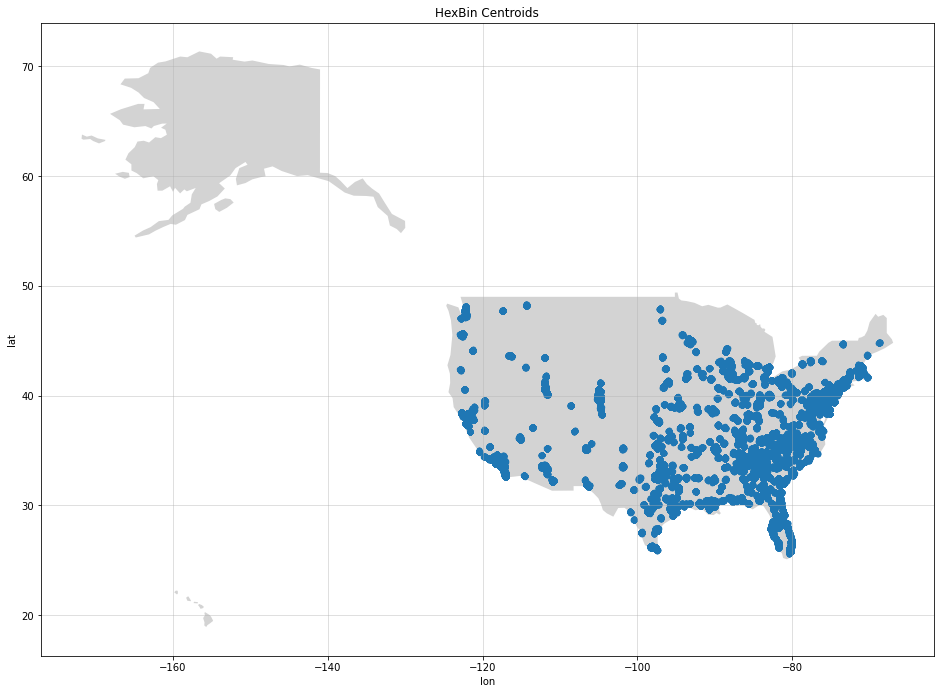

In [12]:
# Initialize axis
fig, ax = plt.subplots(figsize=(16,12))
# Plot map on axis
countries = gpd.read_file(  
     gpd.datasets.get_path("naturalearth_lowres")
)
countries[countries['name'] == 'United States of America'].plot(color="lightgrey", ax=ax)
# Plot Points
df.plot(
    x="lon", 
    y="lat", 
    kind="scatter", 
    colormap="YlOrRd", 
    title='HexBin Centroids', 
    ax=ax
)
# Add Grid
ax.grid(b=True, alpha=0.5)
plt.show()

In [13]:
# Set Coordinate Reference System 
# EPSG = standard system of defining progjections - 4326 == WGS84 (global grid)
gdf = gdf.set_crs('EPSG:4326')

### Export the Data
There is a multitude of ways to export the data. Geopandas supports several different filetypes for both import and export - however, certain filetypes are sensitive to different things. For instance, a Shapefile cannot contain different types of spatial objects (i.e., points and lines) in the same file, and must be broken up. GeoPackages will not accept tuples or lists, and certain software will not automatically recognize the spatial object in a csv.

Personally, I use GeoJSON when the output will be used in QGIS, Tableau, web apps or other Python/R scripts. I use Shapefiles if the data will be further used in ESRI or Alteryx, and headerless csv's for import into data warehouses. 

There are a multiude of methodologies of exporting data, and each filetype has its own limitations and benefits. Ultimately, the data ETL pipeline should define the requirements needed to build a robust, reproducible system. 

In [14]:
# Sample Export methods

gdf.to_file("../../01_Data/02_GeoJSON/market_op.geojson", driver='GeoJSON')
# Athena needs csv to not have a header
gdf.to_csv("../../01_Data/03_CSV_Athena/market_op.csv", index = False, header = False)
# For other purposes, .csv should have header
gdf.to_csv("../../01_Data/04_CSV_Full/market_op.csv", index = False, header = True)